### Example of LAMMPS workflow

- The workflow is partially based on: https://gsalvatovallverdu.gitlab.io/python/2022-18-07-lammps-compute-with-python/
- Data are taken from an example by Simon Gravelle: https://github.com/simongravelle/lammps-input-files/tree/main/inputs/melting-gold

In [1]:
# LAMMPS Python API
import lammps

In [2]:
# For analysis and visualization
import MDAnalysis as md
# 'ase' (Atomic Simulation Environment) could be used instead 
# or in combination to

In [3]:
# For plotting output
import matplotlib.pyplot as plt

In [4]:
# For visualizing trajectories in the notebook
import nglview as ng
# 'ovito' may be used instead

In [5]:
# Other libraries
# import numpy as np
# ... scipy ...
# ... mace ...

In [6]:
def read_lammps_dat(fn,nvar=2) :
    """
        Auxillary function that reads a LAMMPS output .dat file and
        returns a dictionary (keys = variable names)
    """
    data = dict()
    n = 0
    with open(fn, 'r') as file:
        for line in file:
            n += 1
            columns = line.strip().split()
            if line.startswith('#') and n==2 :
                varnames = line.strip('#').split()
                for vn in varnames :
                    data[vn] = []
            elif len(columns) == nvar:
                for i in range(nvar) :
                    data[varnames[i]].append(float(columns[i]))
            else:
                print(f"Skipping line: {line.strip()}")
    return data

In [7]:
lmp = lammps.lammps()

LAMMPS (29 Aug 2024)


In [8]:
!ls

OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
FeAu-eam-LJ.fs	input.lammps  log.lammps  parm.lammps  workflow.ipynb


In [9]:
# Look up for the reference input parameters of the example (optional)
# !cat input.lammps

In [10]:
# This is probably not the best way to go, as it kinda defeats 
# the purpose of having an API in the first place?
# lmp.file("input.lammps")

In [11]:
### SIMULATION PARAMETERS ###

lattice_spacing = 4.065 # [Å]
initial_temperature = 1 # [K]
final_temperature = 2500 # [K]
tdamp = 0.1 # [ps]
dt = 0.001 # [ps]
nsteps = 10000
velocity_seed = 425521
dump_temp_every = 1
dump_temp_repeat = 10
dump_temp_freq = 100
dump_traj = 100
dump_thermodynamics = 100

### --------------------- ###

In [12]:
# Defining auxillary variables
lmp.commands_list([
    'variable fccAu equal '+str(lattice_spacing),
    'variable L1 equal ${fccAu}*8',
    'variable L2 equal ${fccAu}*4',
    'variable Ti equal '+str(initial_temperature),
    'variable Tf equal '+str(final_temperature)
])

In [13]:
# Defining units and boundary styles
lmp.commands_list([
    'units metal',
    'boundary p p p',
    'atom_style atomic'
])

In [14]:
# Defining regions and the computational box
lmp.commands_list([
    'region system block -${L1} ${L1} -${L1} ${L1} -${L1} ${L1}',
    'region cube block -${L2} ${L2} -${L2} ${L2} -${L2} ${L2}',
    'create_box 1 system'
])

In [15]:
# Including the force field
lmp.command('include parm.lammps')

In [16]:
# Creating the lattice
lmp.commands_list([
    'lattice fcc '+str(lattice_spacing),
    'create_atoms 1 region cube',
    'lattice none 1.0'
])

In [17]:
# Initializing ensemble and dynamics
lmp.commands_list([
    'velocity all create ${Ti} '+str(velocity_seed)+' rot yes mom yes dist gaussian',
    'fix mynvt all nvt temp ${Ti} ${Tf} '+str(tdamp),
    'fix myrc all recenter INIT INIT INIT',
    'timestep '+str(dt)
])

In [18]:
# Temperature output
lmp.commands_list([
    'variable mytemp equal temp',
    'fix myat1 all ave/time '+str(dump_temp_every)+' '+str(dump_temp_repeat)+
    ' '+str(dump_temp_freq)+' v_mytemp file temperature.dat'
])

In [19]:
# Define dump frequency for logging
lmp.commands_list([
    'dump dp1 all atom '+str(dump_traj)+' dump.lammpstrj',
    'thermo '+str(dump_thermodynamics)
])

In [20]:
# RUN!
lmp.command('run '+str(nsteps))

Created orthogonal box = (-32.52 -32.52 -32.52) to (32.52 32.52 32.52)
  1 by 1 by 1 MPI processor grid
Lattice spacing in x,y,z = 4.065 4.065 4.065
Created 2457 atoms
  using lattice units in orthogonal box = (-32.52 -32.52 -32.52) to (32.52 32.52 32.52)
  create_atoms CPU = 0.001 seconds
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 10.25
  ghost atom cutoff = 10.25
  binsize = 5.125, bins = 13 13 13
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair eam/fs, perpetual
      attributes: half, newton on
      pair build: half/bin/atomonly/newton
      stencil: half/bin/3d
      bin: standard
Setting up Verlet run ...
  Unit style    : metal
  Current step  : 0
  Time step     : 0.001
Per MPI rank memory allocation (min/avg/max) = 4.11 | 4.11 | 4.11 Mbytes
   Step          Temp          E_pair         E_mol          TotEng         Press     
         0   1       

In [21]:
!head temperature.dat

603    
      8300   2119.4037     -7593.8743      0             -6921.0422     -806.71195    
      8400   2111.9787     -7565.6557      0             -6895.1808     -994.61311    
      8500   2108.9218     -7543.4353      0             -6873.9308     -1496.2849    
      8600   2142.6398     -7521.0775      0             -6840.8688     -811.49261    
      8700   2157.5668     -7487.3995      0             -6802.4521     -80.960029    
      8800   2246.1465     -7471.0504      0             -6757.9822     -17.833032    
      8900   2266.6215     -7458.5965      0             -6739.0282      271.74021    
      9000   2207.8526     -7442.2108      0             -6741.2995      151.66858    
      9100   2241.0816     -7431.4207      0             -6719.9604      114.07049    
      9200   2290.0396     -7404.0879      0             -6677.0853      611.16797    
      9300   2329.8083     -7366.6137      0             -6626.9859      1153.2406    
      9400   2407.7575     -7356.40

In [22]:
temperature = read_lammps_dat('temperature.dat')

Skipping line: # Time-averaged data for fix myat1


<IPython.core.display.Javascript object>


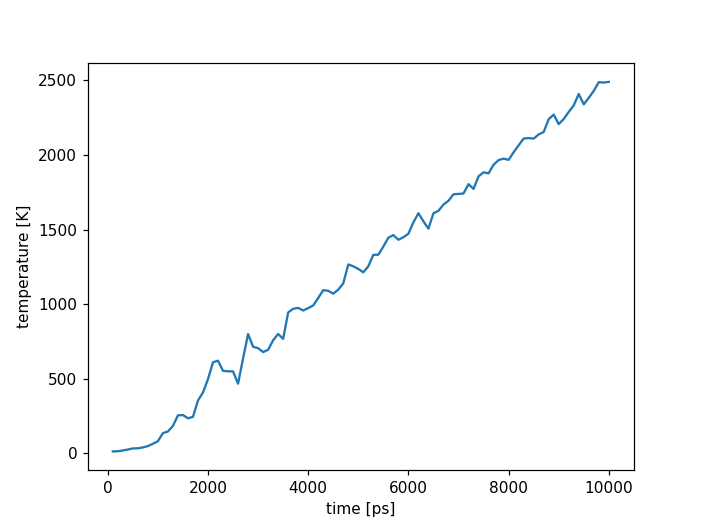

In [23]:
%matplotlib notebook

plt.plot(temperature['TimeStep'],temperature['v_mytemp'])
plt.xlabel('time [ps]')
plt.ylabel('temperature [K]')
plt.show()

In [24]:
# Necessary since MDAnalysis won't read .lammpstrj files...
!cp dump.lammpstrj dump.lammpsdump

In [25]:
# Quick and dirty solution, it would be better to pass 
# a topology file as input
unilmp = md.Universe('dump.lammpsdump', atom_style='id type x y z')

/home/michele/mambaforge/envs/workflow-hea/lib/python3.10/site-packages/MDAnalysis/topology/LAMMPSParser.py:632: UserWarning: Guessed all Masses to 1.0
  warnings.warn('Guessed all Masses to 1.0')
/home/michele/mambaforge/envs/workflow-hea/lib/python3.10/site-packages/MDAnalysis/coordinates/LAMMPS.py:598: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt


In [26]:
ngview1 = ng.show_mdanalysis(unilmp)
ngview1

NGLWidget(max_frame=100)

In [27]:
lmp.close()